In [2]:
import pandas as pd
import numpy as np 
import math as mt
import s3fs
import zipfile
import os
import matplotlib.pyplot as plt

class s3_connection():
    def __init__(self):
        """
        établir la connexion et après utiliser les fonction de read et write 
        """
        try:
         s3 = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
         
         print("connection successful")
         
        except:
         s3="connection not established, debug "
         print(s3)
        self.s3=s3
    def listt(self, directory):
        return((self.s3.ls(directory)))

    def unzip(self,from_s,to_s):
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)

    
    def from_pandas_to_parquet_store_in_s3(self,df, directory):
      try:
        with self.s3.open(directory, "wb") as file_out:
         df.to_parquet(file_out)
      except: 
        print("Cher lecteur, cette fonction écrit dans le dossier spécifié, mais vous n'avez pas les droits :( ")
      
    
    def get_tables_from_s3(self,directory):
        
        with self.s3.open(directory, "rb") as file_in:
          df = pd.read_parquet(file_in)
        return df
 

In [3]:
  
    
s3=s3_connection()
directory="aayrapetyan/diffusion/"
tables=s3.listt(directory)

dataframes = {}
words_to_remove = ["aayrapetyan", "diffusion", ".us", "--", "usd-spot","parquet"]
import re
# Loop through all files in the folder
for file_name in tables:
    if file_name.endswith('.parquet') and "final_table" not in file_name:  # Check if the file is a Parquet file
        
        try:
            # Read the Parquet file into a DataFrame
            df = s3.get_tables_from_s3(file_name)
            # Store the DataFrame using the file name (without extension) as the key
            pattern = "|".join(re.escape(word) for word in words_to_remove)
            cleaned_string = re.sub(pattern, "", file_name)
            cleaned_string = re.sub(r"[/\.]+", "/", cleaned_string).strip("/")[0:-1]
            dataframes[cleaned_string] = df
            print(f"Loaded {file_name} successfully!")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

for key in dataframes.keys():
    print(key)

dataframes["ftx-dai"]

connection successful
Loaded aayrapetyan/diffusion/binance.us-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/binance.us-usdc-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/binance.us-usdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-usdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-wluna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-cusdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-luna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-luna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-usdc-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-usdt-usd-spot.parquet successfully!
binance-dai
binance-usdc
binance-us

,market,time,coin_metrics_id,amount,price,database_time,side
0,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428441,3028.9,1.0,2022-01-01 00:20:00.075013+00:00,buy
1,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428442,2000.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
2,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428443,1.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
3,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428444,5.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
4,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428445,2150.2,1.0,2022-01-01 00:20:00.075013+00:00,buy
...,...,...,...,...,...,...,...
126811,ftx-dai-usd-spot,2022-11-12 03:22:06.088667+00:00,5412623105,29.1,1.013,2022-11-12 03:22:06.375870+00:00,sell
126812,ftx-dai-usd-spot,2022-11-12 03:22:06.224272+00:00,5412623109,49.4,1.013,2022-11-12 03:22:06.375870+00:00,sell
126813,ftx-dai-usd-spot,2022-11-12 03:22:06.258189+00:00,5412623113,29.5,1.013,2022-11-12 03:22:06.375870+00:00,sell
126814,ftx-dai-usd-spot,2022-11-12 03:22:06.354345+00:00,5412623119,42.2,1.013,2022-11-12 03:22:06.625909+00:00,sell


In [4]:
def remove_outliers(df, columns):
    """
    Remove outliers from the specified columns of a DataFrame.
    Outliers are defined as values that are more than 3 standard deviations away from the mean.
    Prints the number of outliers removed for each column.
    """
    for column in columns:
        if column in df.columns:
            # Calcul des bornes
            mean = df[column].mean()
            std = df[column].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            
            # Calcul du nombre de valeurs initiales
            initial_count = len(df)
            
            # Filtrage des valeurs dans les bornes
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            
            # Nombre de valeurs supprimées
            final_count = len(df)
            print(f"{column}: {initial_count - final_count} outliers removed")
            
    return df


In [5]:
def plot_stablecoin_prices(stablecoin, title,dataframes):
    plt.figure(figsize=(30, 6))
    # for platform, df in dataframes_dict.items():
    #     if stablecoin in platform:
    plt.plot(dataframes[stablecoin]['time'], dataframes[stablecoin]['price'])
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_stablecoin_prices_multi(stablecoins, title, dataframes):
    """
    Trace les prix de plusieurs stablecoins sur le même graphique.
    """
    
    plt.figure(figsize=(32, 6))
    for stablecoin in stablecoins:
        if stablecoin in dataframes:
            df = dataframes[stablecoin]
            plt.plot(df['time'], df['price'], label=stablecoin)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Etude de DAI

## Avant la rejection des outliers

/tmp/ipykernel_2915/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


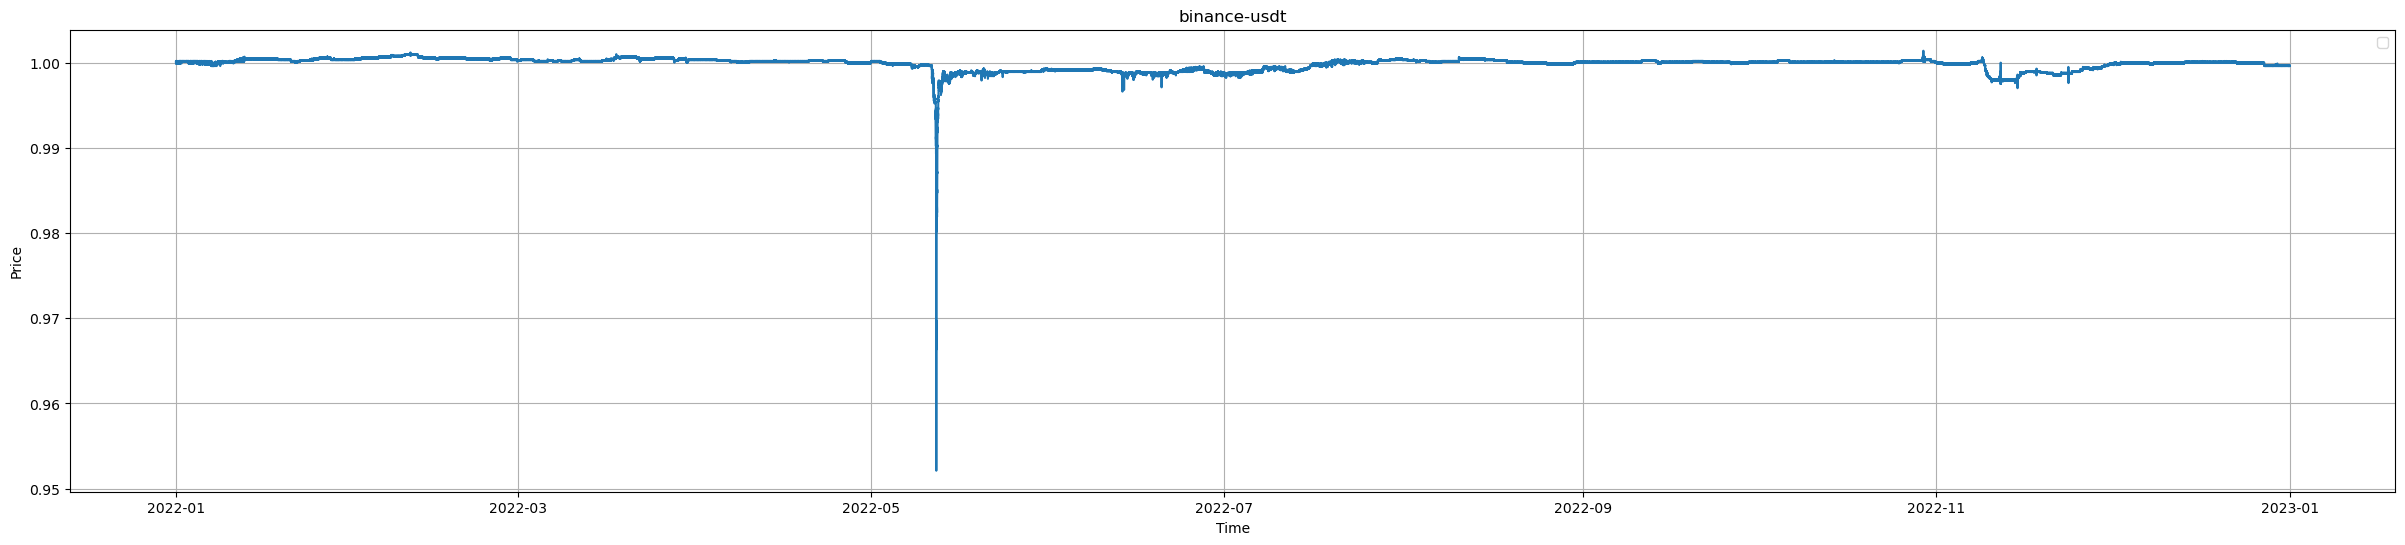

/tmp/ipykernel_2915/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


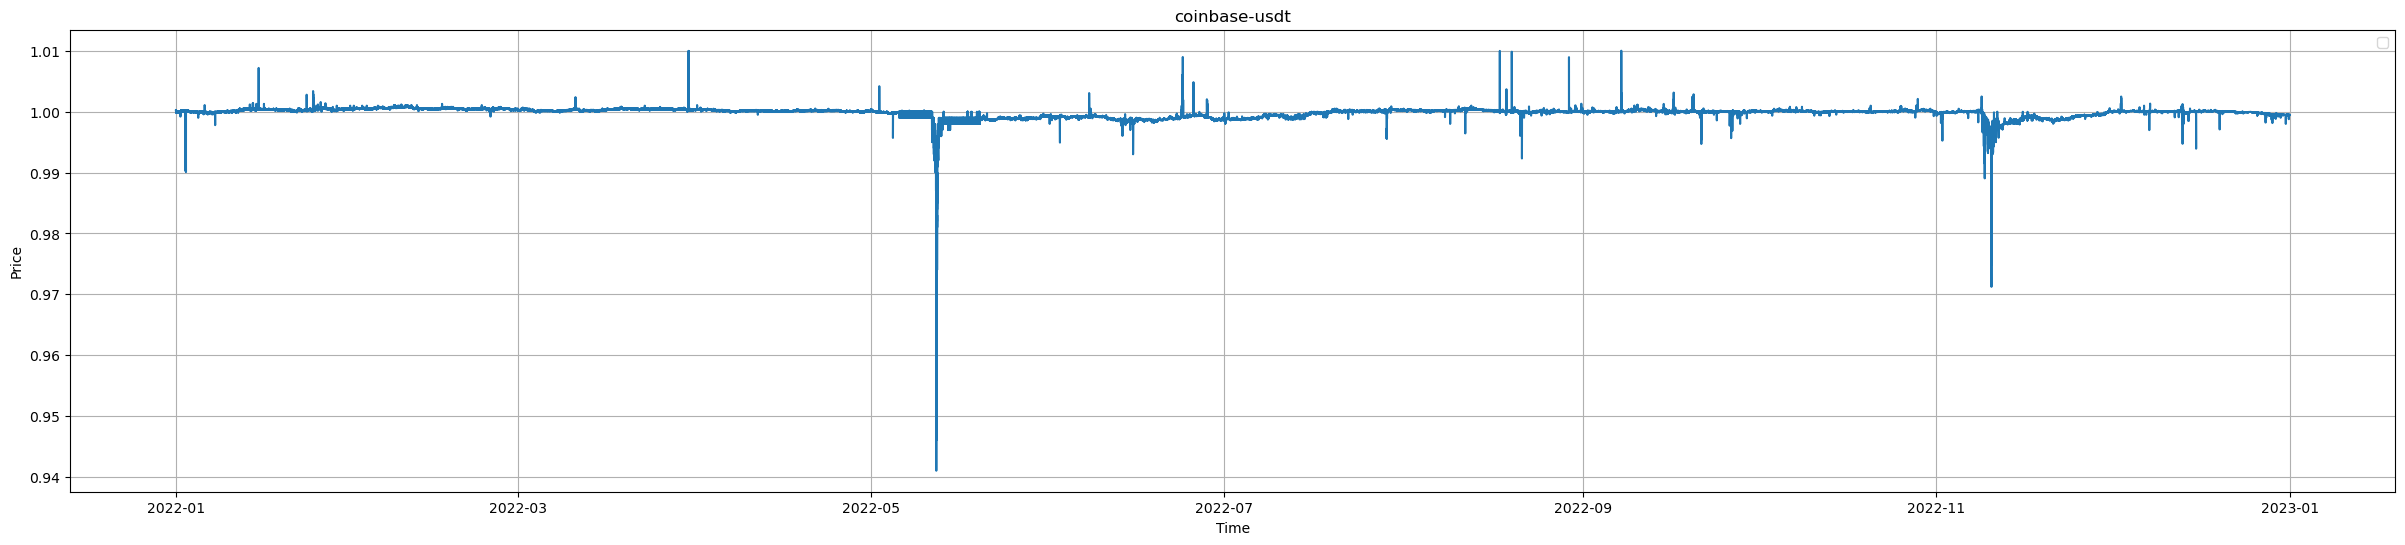

/tmp/ipykernel_2915/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


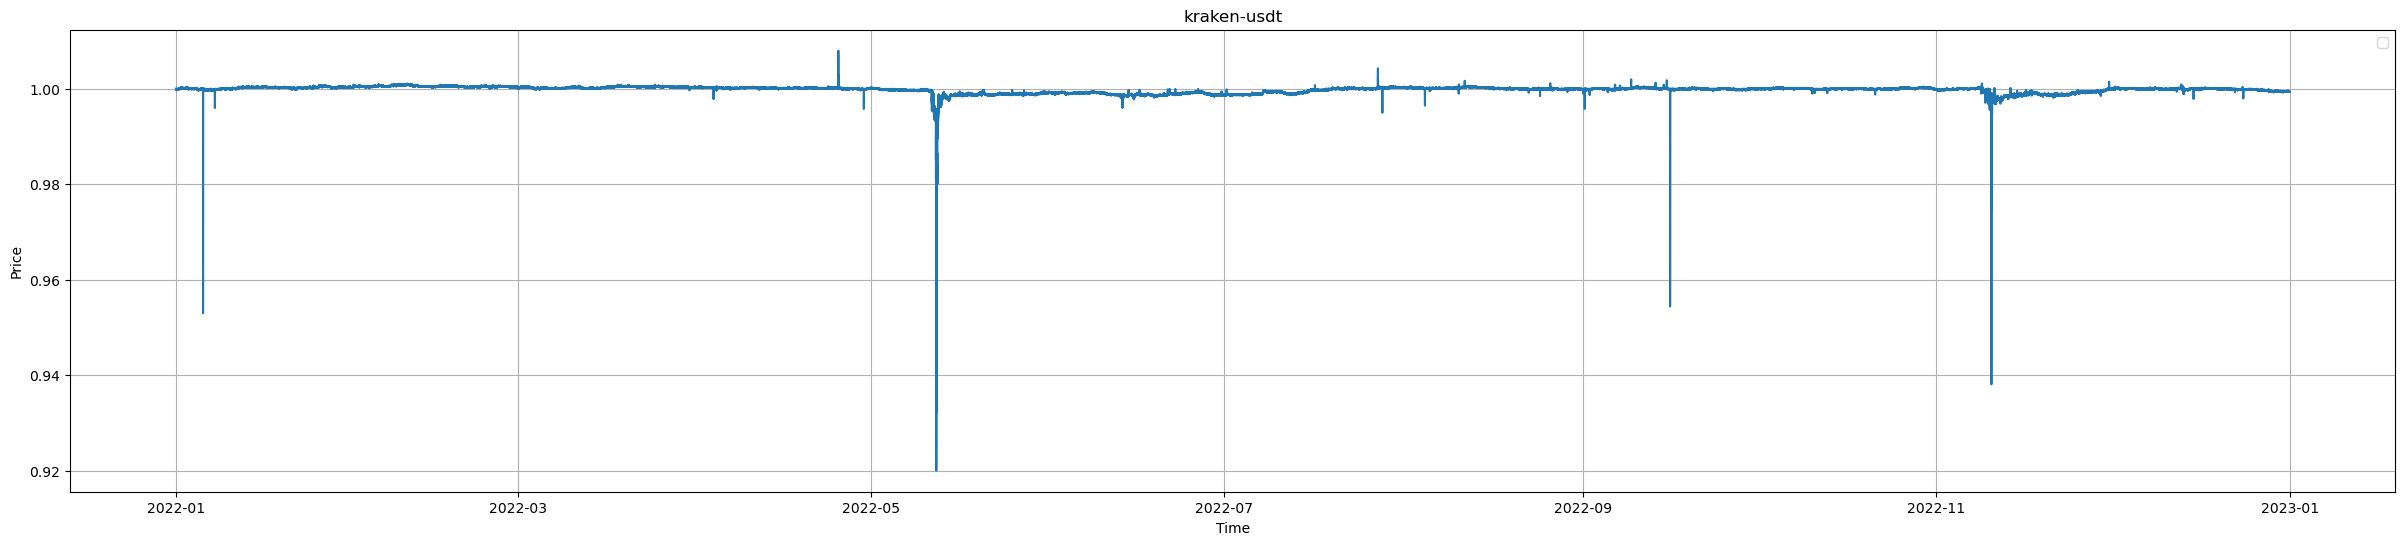

In [7]:
plot_stablecoin_prices("binance-usdt","binance-usdt",dataframes)
plot_stablecoin_prices("coinbase-usdt","coinbase-usdt",dataframes)

plot_stablecoin_prices("kraken-usdt","kraken-usdt",dataframes)

## On remarque pour les 3 graphes un pic important en mai 2022, qui ne devrait donc pas etre un outlier et un autre un peu moins prononcé en novembre 2022 (encore moins prononcé sur binance)

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


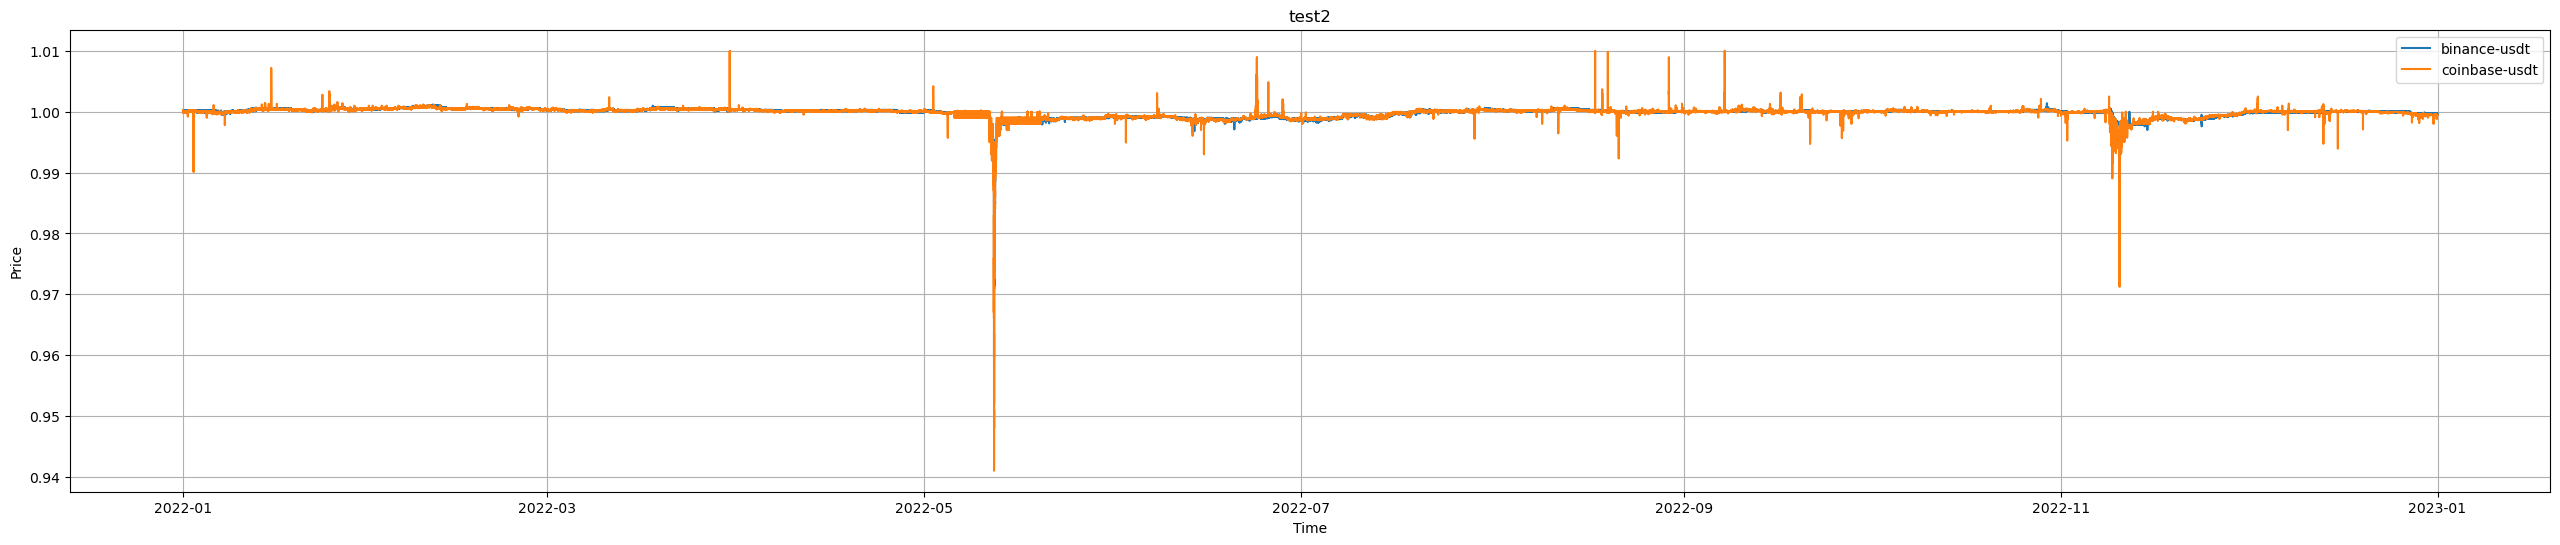

In [9]:
plot_stablecoin_prices_multi(["binance-usdt","coinbase-usdt"],"test2",dataframes)

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


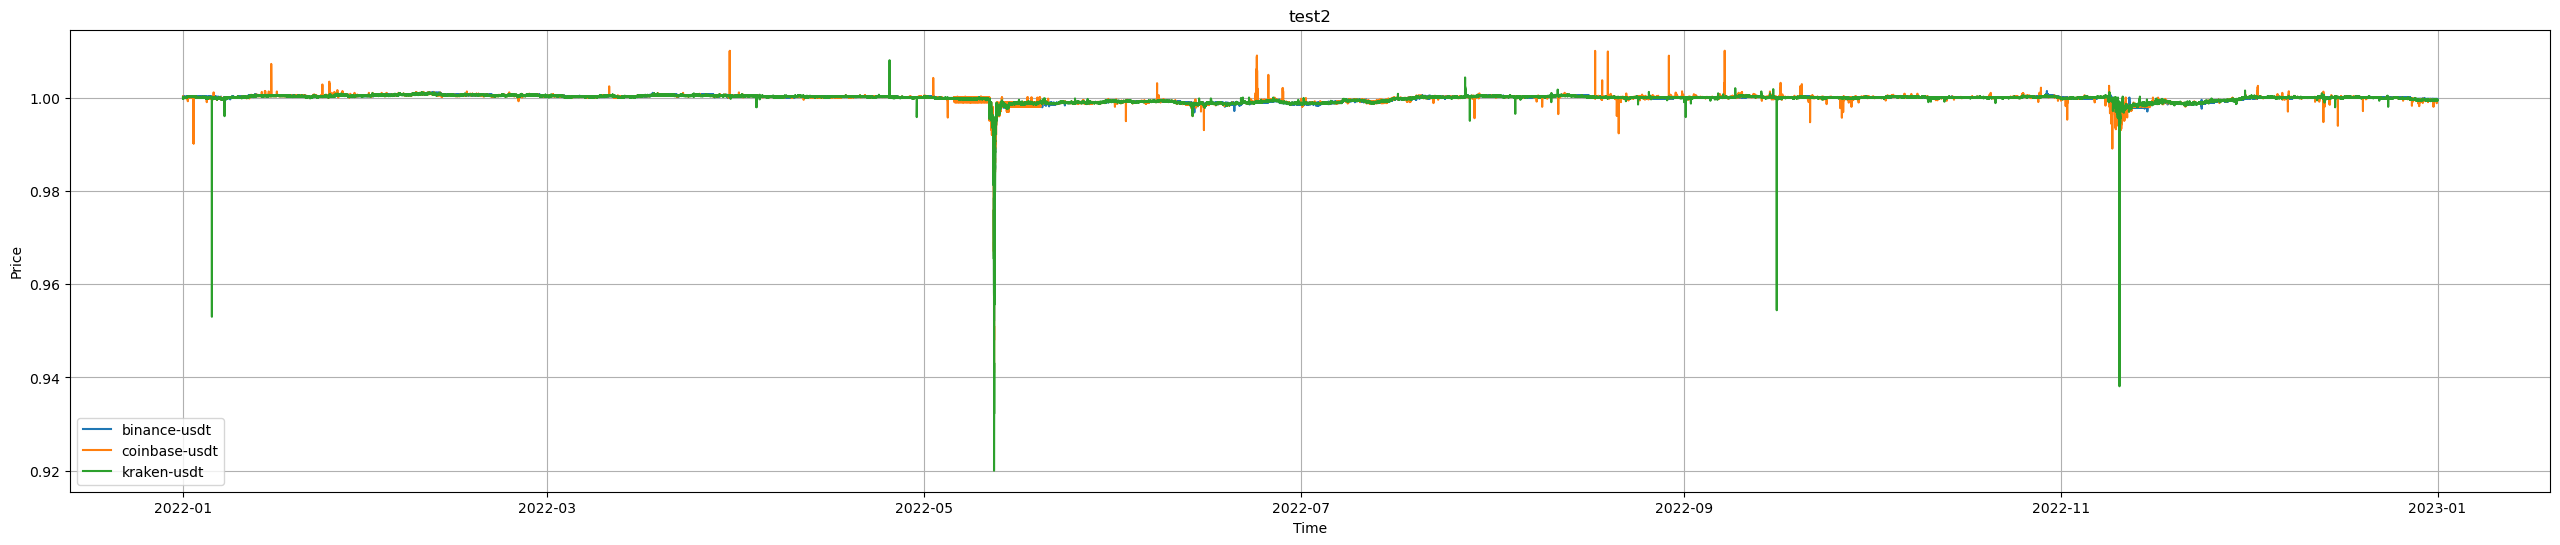

In [8]:
plot_stablecoin_prices_multi(["binance-usdt","coinbase-usdt","kraken-usdt"],"test2",dataframes)

## Après la rejection des outliers

In [7]:
dataframes["new-binance-usdt"] = remove_outliers(dataframes["binance-usdt"], ["price"])
dataframes["new-coinbase-usdt"] = remove_outliers(dataframes["coinbase-usdt"], ["price"])
dataframes["new-kraken-usdt"] = remove_outliers(dataframes["kraken-usdt"], ["price"])


price: 46165 outliers removed
price: 136704 outliers removed
price: 107212 outliers removed


/tmp/ipykernel_21297/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


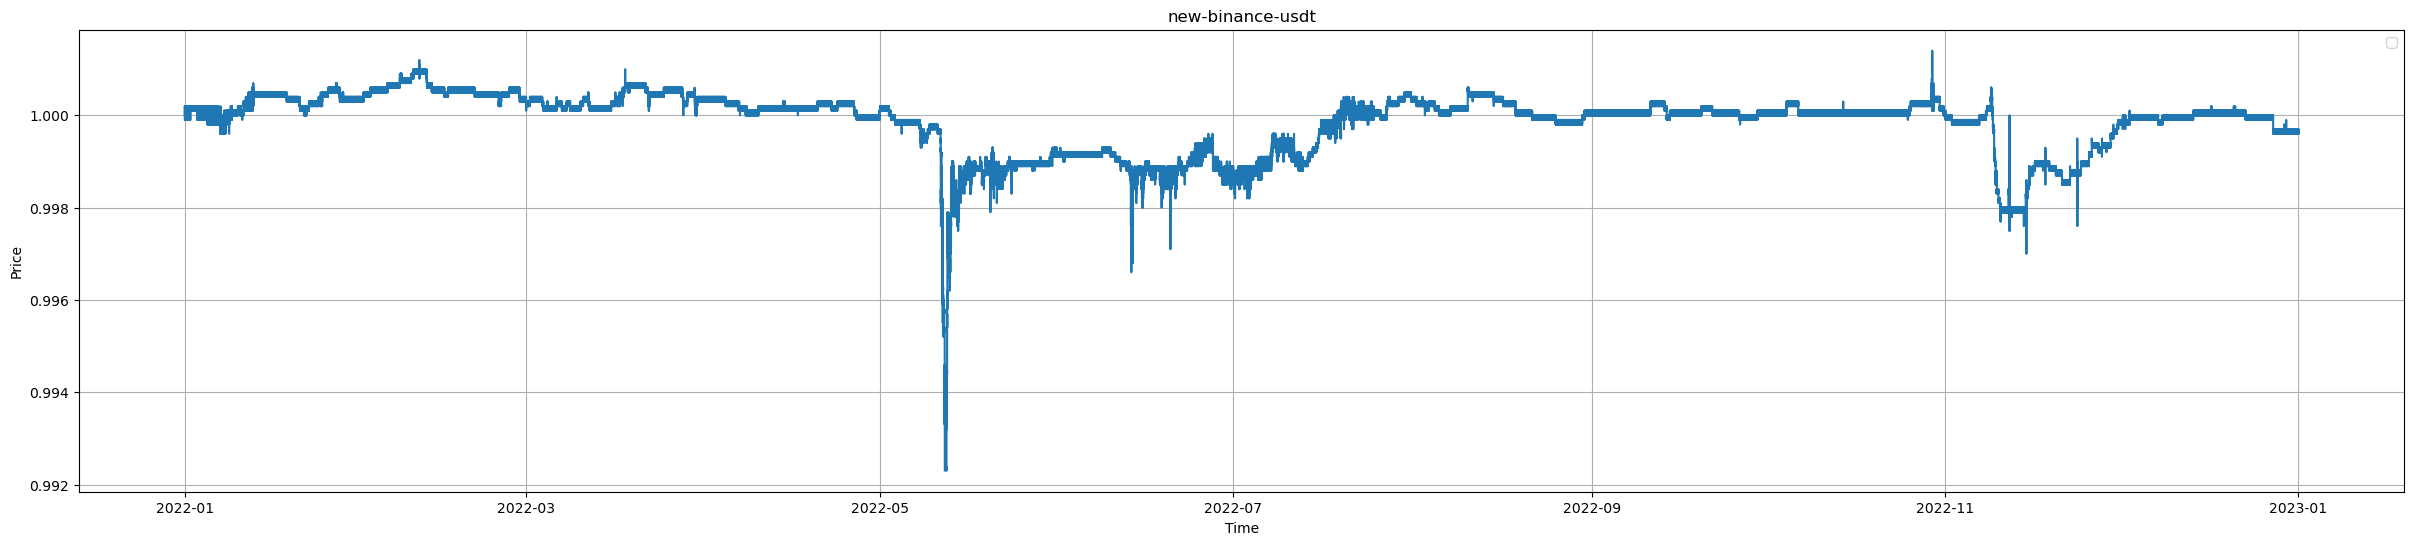

/tmp/ipykernel_21297/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


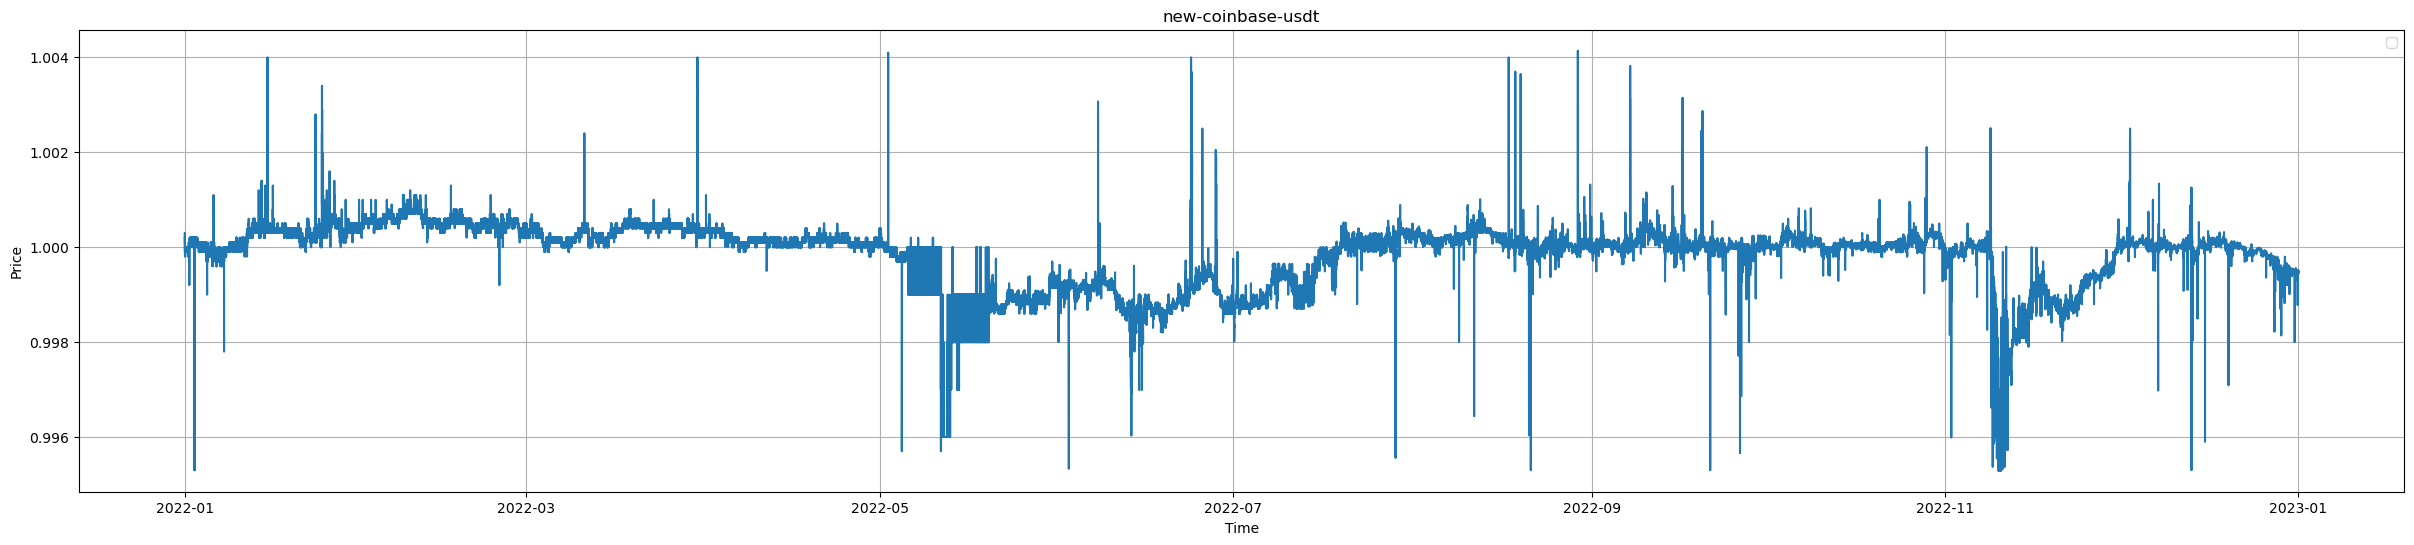

/tmp/ipykernel_21297/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


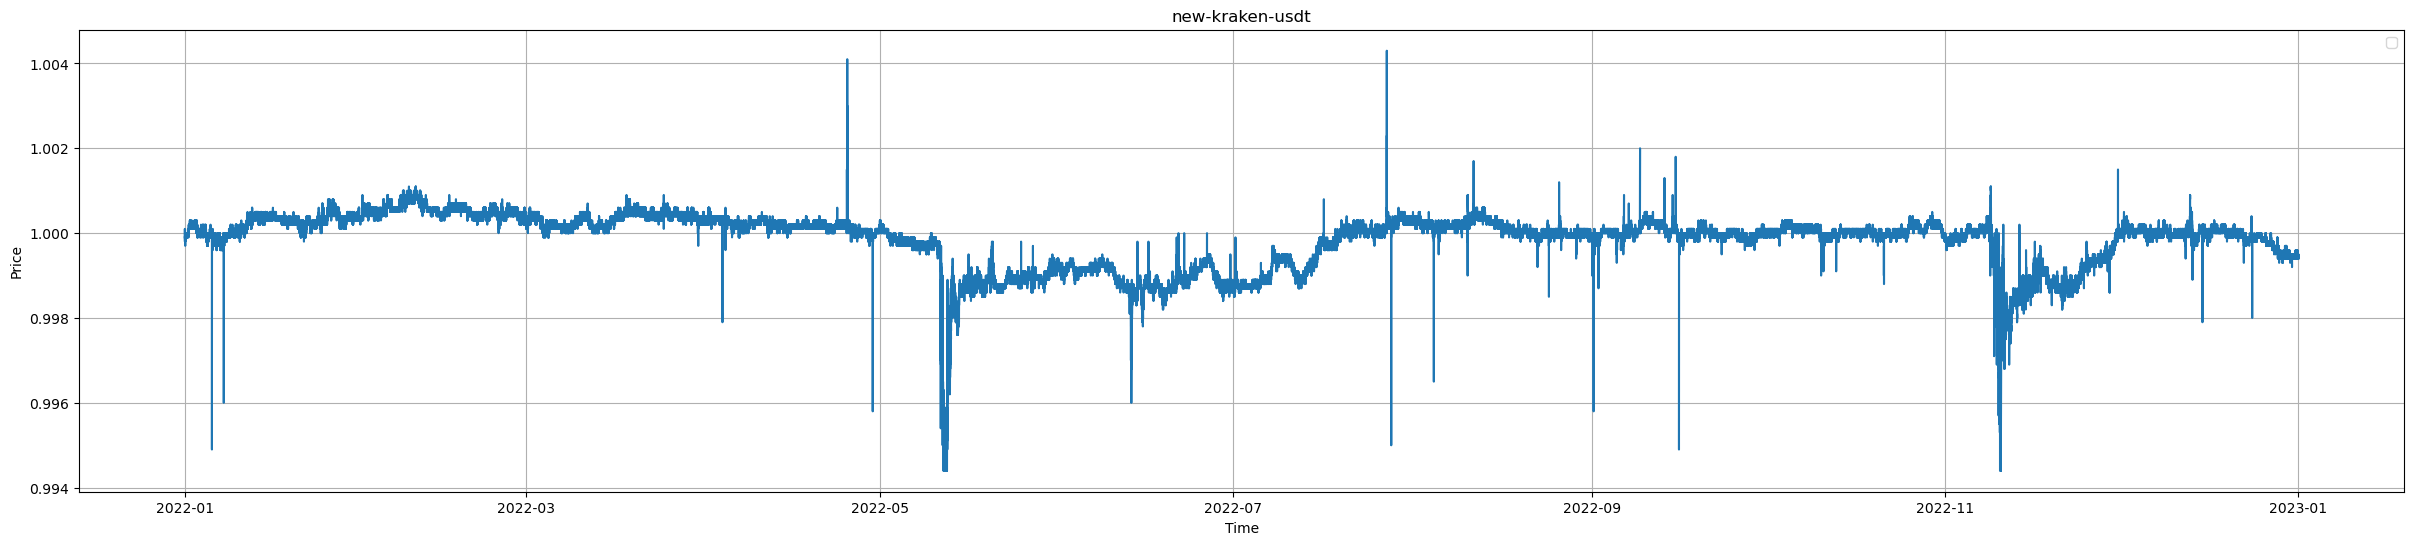

In [8]:
plot_stablecoin_prices("new-binance-usdt","new-binance-usdt",dataframes)
plot_stablecoin_prices("new-coinbase-usdt","new-coinbase-usdt",dataframes)
plot_stablecoin_prices("new-kraken-usdt","new-kraken-usdt",dataframes)

## On voit bien encore qu'il y a un pic (outliers ? ) en mai 2022 et novembre 2022

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


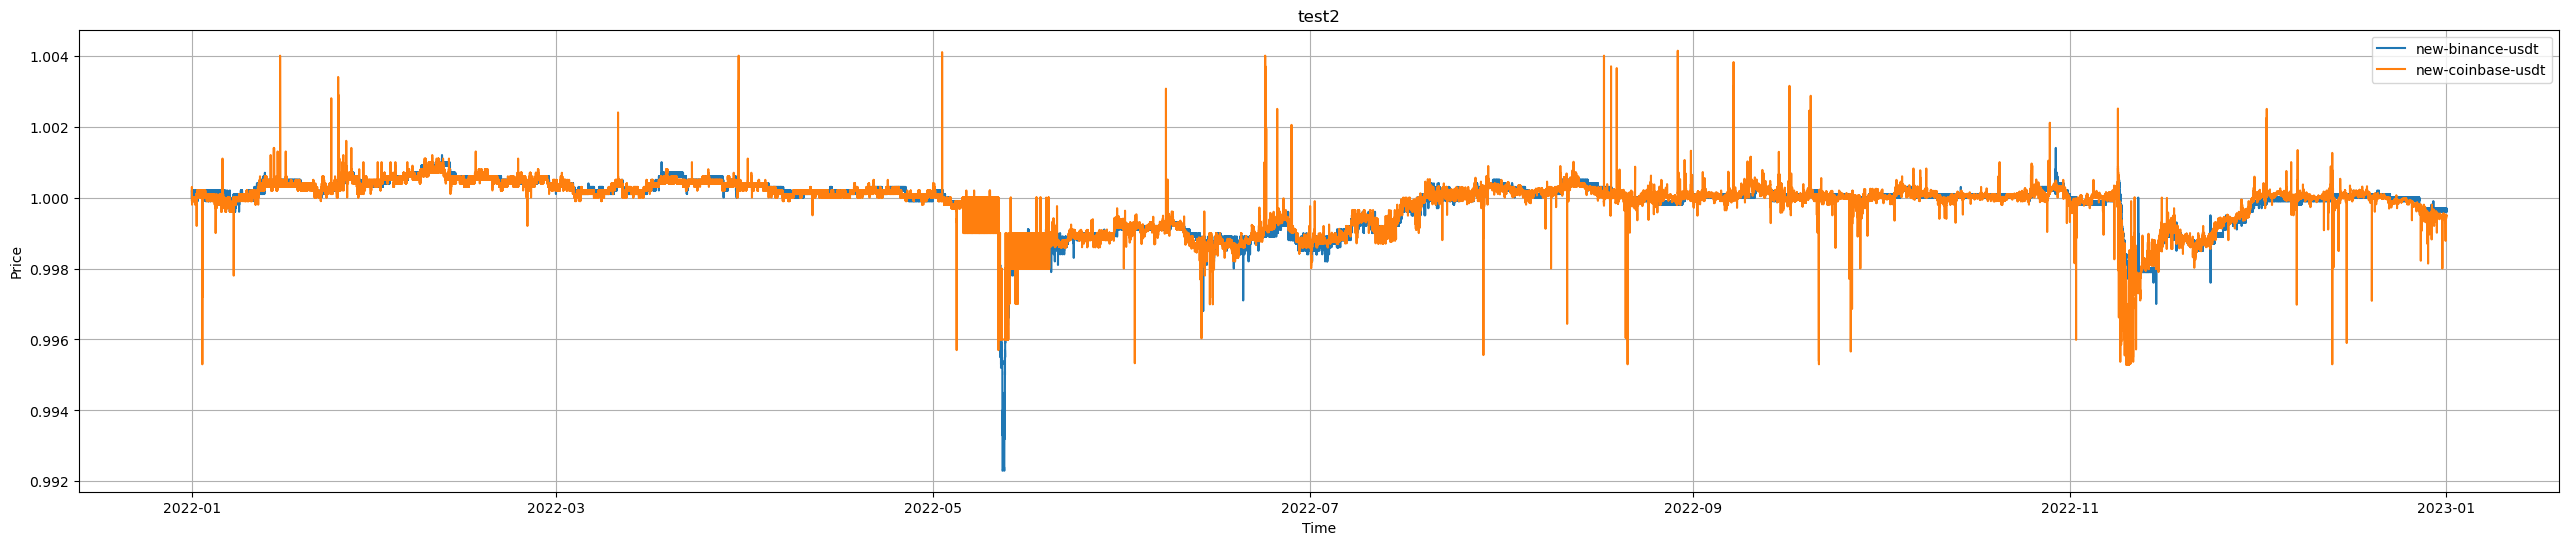

In [9]:
plot_stablecoin_prices_multi(["new-binance-usdt","new-coinbase-usdt"],"test2",dataframes)

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


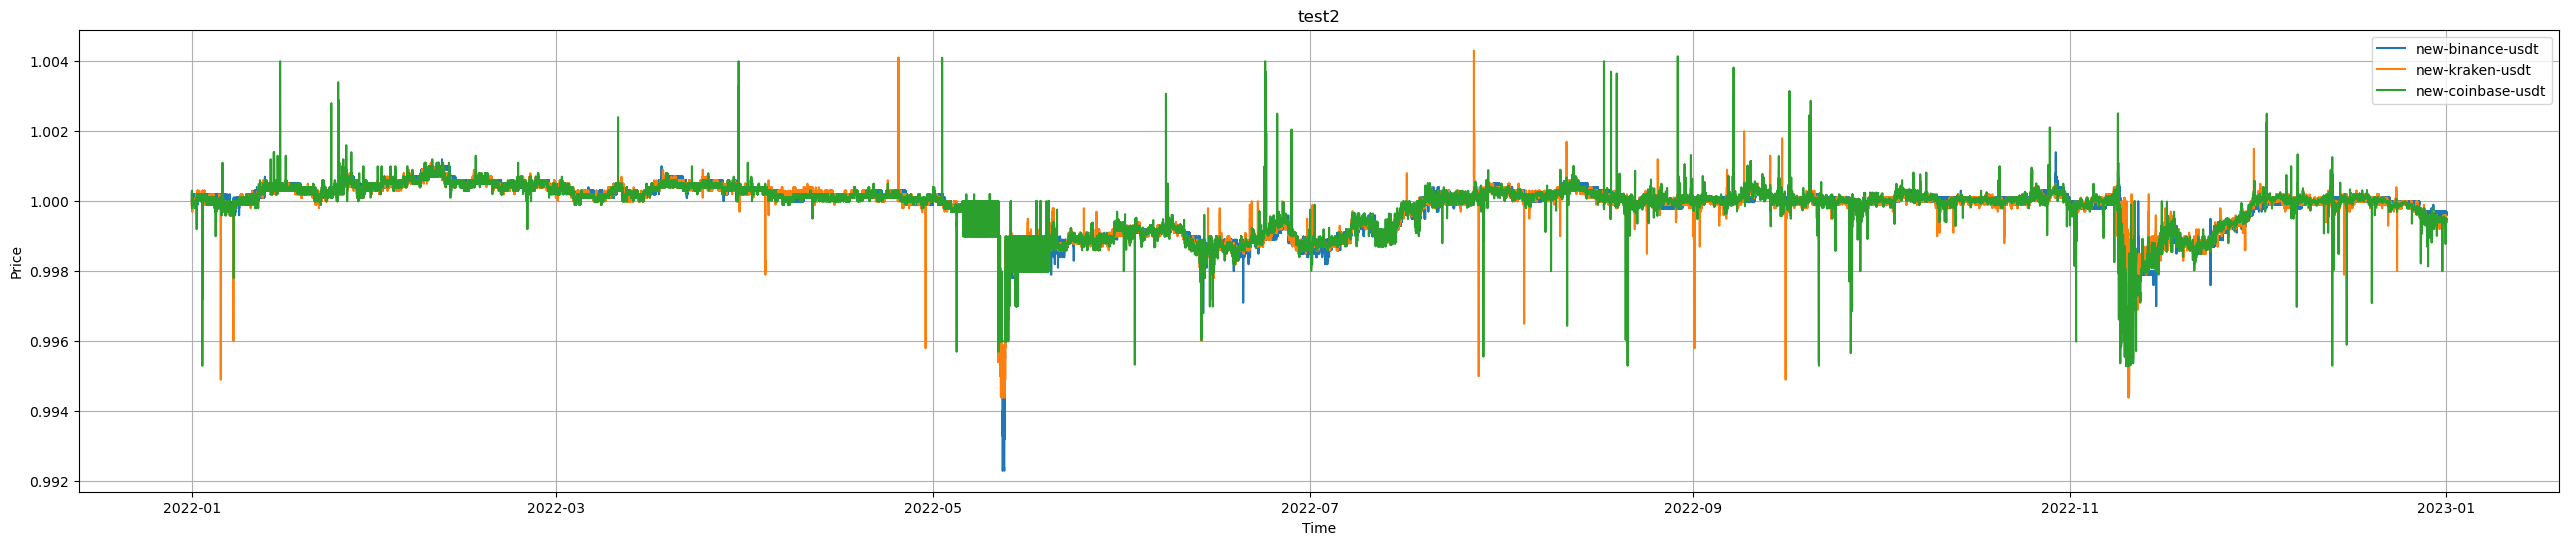

In [10]:
plot_stablecoin_prices_multi(["new-binance-usdt","new-kraken-usdt","new-coinbase-usdt"],"test2",dataframes)
# plot_stablecoin_prices_multi(["new-binance-dai","new-coinbase-dai","new-ftx-dai","new-kraken-dai"],"test2",dataframes)